In [ ]:
import os
from pathlib import Path
import imageio, numpy
from PIL import Image, ImageDraw, ImageFont

def search_files(directory):
    mp4Path = []
    dataPath = {}
    path = Path(directory)
    for file in path.rglob("*"):  # 递归搜索所有文件
        if file.is_file():  # 确保是文件
            tmp = file.name[0:-4]
            extension = file.name[-3:]
            if extension == "mp4": 
                mp4Path.append(str(file))
            elif extension == "txt": 
                tmp2 = str(tmp).split("+")
                scene_name = tmp2[0]
                id = tmp2[1]
                scene_id = scene_name + ".mp4"
                if scene_id not in dataPath:
                    dataPath[scene_id] = {}
                dataPath[scene_id][id] = str(file)
            
            
            
    return mp4Path, dataPath

# 示例：搜索当前文件夹下的所有文件
mp4Path, dataPath = search_files("/home/jjlin/pluto/result")

mp4Path
dataPath




In [23]:
import numpy as np
from scipy.signal import lfilter
 
def low_pass_filter(data, cutoff):
    b = [0.25, 0.5, 0.25]  # 简单的低通滤波器系数，例如三角窗滤波器
    a = [1.0]  # 分母系数为1，表示无延迟滤波器
    filtered_data = lfilter(b, a, data)
    return filtered_data
 
cutoff = 0.5  # 这里cutoff参数通常用于设计滤波器，具体值根据需要而定


In [36]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os


def load_data_from_mat(path):
    # 加载 .mat 文件
    mat_data = scipy.io.loadmat(path)

    # 显示 .mat 文件中的键（变量名）
    #print("Keys in the .mat file:", mat_data.keys())

    # print("Keys in the .mat file:", mat_data["data_3"].dtype.names)

    i = 1
    emergency = []
    traj_var = []
    prob_var = []
    traj_chosed = []
    final_score = []
    pred_var = []
    e_traj_var = []
    rule_based_scores = []
    final_scores = []
    step_time = []
    metrics = []
    TTC = []
    is_e_traj = False
    #if mat_data["1"]["e_traj_var"]:
    #    is_e_traj = True

    while str(i) in mat_data.keys():
        #print(mat_data[str(i)].dtype.names)
        emergency.append(mat_data[str(i)]["emergency"][0, 0][0, 0])
        traj_var.append(mat_data[str(i)]["traj_var"][0, 0][0, 0])
        prob_var.append(mat_data[str(i)]["prob_var"][0, 0][0, 0])
        final_score.append(mat_data[str(i)]["final_score"][0, 0][0, 0])
        final_scores.append(mat_data[str(i)]["final_scores"][0, 0][0])
        rule_based_scores.append(mat_data[str(i)]["rule_based_scores"][0, 0])
        pred_var.append(mat_data[str(i)]["pred_var"][0, 0][0])
        e_traj_var.append(mat_data[str(i)]["e_traj_var"][0, 0][0, 0] if is_e_traj else 0)
        step_time.append(mat_data[str(i)]["step_time"][0, 0][0, 0])
        metrics.append(mat_data[str(i)]["metrics"][0, 0][0])
        TTC.append(mat_data[str(i)]["TTC"][0, 0][0])  # TTC of every cand traj
        i += 1
    time = range(1, i)
    return time, emergency, traj_var, prob_var, final_score, final_scores, rule_based_scores, pred_var, e_traj_var, step_time, metrics, TTC


def get_mat_files(folder_path):
    mat_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mat'):
                absolute_path = os.path.abspath(os.path.join(root, file))
                mat_files.append(absolute_path)
    return mat_files

def load_summary_data_from_mat(path):
    mat_data = scipy.io.loadmat(path)
    metrics = []
    TTC = []
    velocity = []
    #if mat_data["1"]["e_traj_var"]:
    #    is_e_traj = True
    i = 1
    if_emergency = False
    while str(i) in mat_data.keys():
        metrics.append(mat_data[str(i)]["metrics"][0, 0][0])
        TTC.append(mat_data[str(i)]["TTC"][0, 0][0])  # TTC of every cand traj
        velocity.append(mat_data[str(i)]["velocity"][0, 0][0, 0])
        if mat_data[str(i)]["emergency"][0, 0][0, 0]:
            if_emergency = True
        i += 1
    mean_metrics = cal_mean_metric(metrics)
    mean_velocity = np.mean(np.stack(velocity))
    return mean_metrics, mean_velocity, if_emergency, 

def cal_mean_metric(metrics):
    sum_metrics = np.zeros(7)
    for metrics_per_step in metrics:
        sum_metrics += metrics_per_step
    mean_metrics = sum_metrics / len(metrics) * 100
    return mean_metrics

#pred_var
# emergency
#rule_based_scores[0]

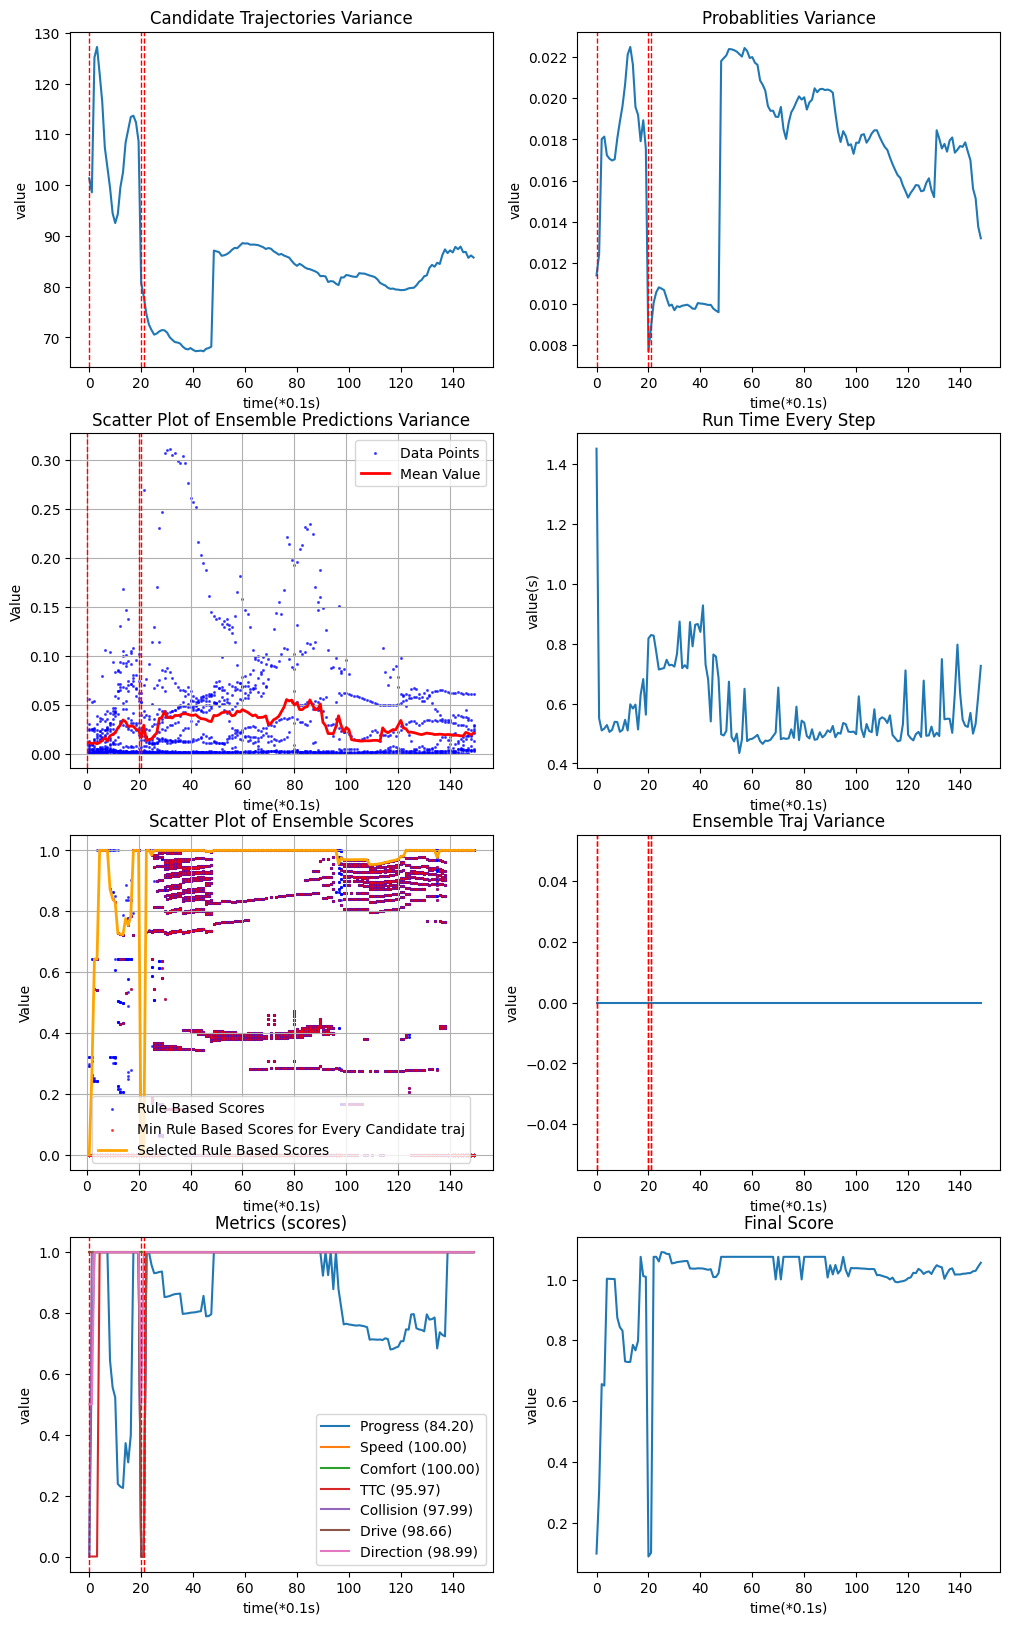

In [23]:
path = '/home/jjlin/pluto_dev/result/log/2021.08.17.16.57.11_veh-08_01200_01636_9e30155b8bb55fd9_pe_t.ckpt.mat'
time, emergency, traj_var, prob_var, final_score, final_scores, rule_based_scores, pred_var, e_traj_var, step_time, metrics = load_data_from_mat(path)

fig, ax = plt.subplots(4,2,figsize=(12,20))

ax[0,0].plot(traj_var,  label='traj var')
ax[0,0].set_title("Candidate Trajectories Variance")
ax[0,0].set_xlabel("time(*0.1s)")
ax[0,0].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[0,0].axvline(x=i, color='r',linestyle='--', linewidth=1)

ax[0,1].plot(prob_var,  label='prob var')
ax[0,1].set_title("Probablities Variance")
ax[0,1].set_xlabel("time(*0.1s)")
ax[0,1].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[0,1].axvline(x=i, color='r',linestyle='--', linewidth=1)


# 绘制散点图
for t, arr in zip(time, pred_var):
    ax[1,0].scatter([t] * arr.shape[0], arr,s=1.5, color='blue', alpha=0.6, label='Data Points' if t == time[0] else "")

# 计算每个时间点的平均值
means = [np.mean(arr) for arr in pred_var]

# 绘制平均值折线图
ax[1,0].plot(time, means, color='red',linestyle='-', linewidth=2, label='Mean Value')

# 添加标签和标题
ax[1,0].set_xlabel("time(*0.1s)")
ax[1,0].set_ylabel("Value")
ax[1,0].set_title('Scatter Plot of Ensemble Predictions Variance')
ax[1,0].legend()
ax[1,0].grid(True)
for i, e in enumerate(emergency):
    if e:
        ax[1,0].axvline(x=i, color='r',linestyle='--', linewidth=1)
#ax[1,1].plot([100 if e else 0 for e in emergency],  label='final score')

ax[1,1].plot(step_time,  label='step time')
ax[1,1].set_title("Run Time Every Step")
ax[1,1].set_xlabel("time(*0.1s)")
ax[1,1].set_ylabel("value(s)")
for i, e in enumerate(emergency):
    if False:
        ax[1,1].axvline(x=i, color='r',linestyle='--', linewidth=1)


# 绘制散点图
for t, arr in zip(time, rule_based_scores):
    ax[2,0].scatter([t] * arr.shape[0] * arr.shape[1], arr,s=1.5, color='blue', alpha=0.6, label='Rule Based Scores' if t == time[0] else "")
    ax[2,0].scatter([t] * arr.shape[1], np.min(arr, axis=0),s=1.5, color='red', alpha=0.6, label='Min Rule Based Scores for Every Candidate traj' if t == time[0] else "")
    
    #print(arr)
    #break
# 计算每个时间点的平均值
mins = [np.min(arr, axis=0) for arr in rule_based_scores]
ax[2,0].plot(time, [max(m) for m in mins], color='orange',linestyle='-', linewidth=2, label='Selected Rule Based Scores')


# 添加标签和标题
ax[2,0].set_xlabel("time(*0.1s)")
ax[2,0].set_ylabel("Value")
ax[2,0].set_title('Scatter Plot of Ensemble Scores')
ax[2,0].legend(loc='lower center')
ax[2,0].grid(True)
for i, e in enumerate(emergency):
    if False:
        ax[2,0].axvline(x=i, color='r',linestyle='--', linewidth=1)


ax[2,1].plot(e_traj_var,  label='e traj var')
ax[2,1].set_title("Ensemble Traj Variance")
ax[2,1].set_xlabel("time(*0.1s)")
ax[2,1].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[2,1].axvline(x=i, color='r',linestyle='--', linewidth=1)


mean_metrics = cal_mean_metric(metrics)

ax[3,0].plot(metrics,  label='step time')
ax[3,0].set_title("Metrics (scores)")
ax[3,0].set_xlabel("time(*0.1s)")
ax[3,0].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[3,0].axvline(x=i, color='r',linestyle='--', linewidth=1)
ax[3,0].legend((f'Progress ({mean_metrics[0]:.2f})', 
                f'Speed ({mean_metrics[1]:.2f})', 
                f'Comfort ({mean_metrics[2]:.2f})', 
                f'TTC ({mean_metrics[3]:.2f})', 
                f'Collision ({mean_metrics[4]:.2f})', 
                f'Drive ({mean_metrics[5]:.2f})', 
                f'Direction ({mean_metrics[6]:.2f})'))

ax[3,1].plot(final_score,  label='final score')
ax[3,1].set_title("Final Score")
ax[3,1].set_xlabel("time(*0.1s)")
ax[3,1].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[2,1].axvline(x=i, color='r',linestyle='--', linewidth=1)


plt.show()

In [39]:
dir = '/home/jjlin/pluto_dev/result_pe/log'
mat_files = get_mat_files(dir)
mean_metrics = [load_summary_data_from_mat(file) for file in mat_files]
mean_metrics = np.stack(mean_metrics)
scores = np.mean(mean_metrics, axis=0)
print(f'Progress\t{scores[0]:.2f} \nSpeed\t\t{scores[1]:.2f}\nComfort\t\t{scores[2]:.2f} \nTTC\t\t{scores[3]:.2f}\nCollision\t{scores[4]:.2f} \nDrive\t\t{scores[5]:.2f} \nDirection\t{scores[6]:.2f}')
print(f'Final scores\t{np.mean(scores):.4f}')

Progress	80.03 
Speed		97.06
Comfort		100.00 
TTC		98.83
Collision	98.62 
Drive		93.23 
Direction	96.29
Final scores	94.8648
